In [2]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

In [3]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32365       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf=1            ## value of resampling
session_now = 2
BINS = 70
FR_limit = 12
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [4]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [5]:
confusion_matrix_data_list = []
performance_sup = np.zeros((10,4))
performance_sup_std = np.zeros((10,4))

confusion_matrix_cca_list = []
performance_cca = np.zeros((10,4))
performance_cca_std = np.zeros((10,4))

# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
confusion_matrix_data = []
confusion_matrix_pca = []
confusion_matrix_cca = []

print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
        

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR


In [6]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 4        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 4        


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4  

            

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [22]:
print('DIMENSIONALITY REDUCCION AND TRAIN CLASSIFIER')
            
dim = 2
kfold_number = 3
kf = KFold(n_splits=kfold_number)
gnb = GaussianNB()
svmclass = svm.SVC()

pipe_pca = Pipeline([('pca', PCA()), ('NGauss', GaussianNB())])
pipe_pca.set_params(pca__n_components= 5)
pipe_pca_svm = Pipeline([('pca', PCA()), ('SVM', svm.SVC())])
pipe_pca_svm.set_params(pca__n_components = 5)

cca = CCA(n_components=5)

gnb_training_list = []
svm_training_list = []

pca_gnb_training_list = []
pca_svm_training_list = []

cca_training_list = []
cca_gnb_training_list = []
cca_svm_training_list = []

testing_input_list = []
testing_output_list = []
          
for day in [0,1,2,3]:
    
    ### prepare neural data
    Xpre_all = activity_list[day].T
    firing_rate = np.mean(Xpre_all,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpre_all = Xpre_all[:,selected_cells]

    for trial in range(5):
        
        print('Trial = ' + f'{day*5+trial+1}')
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.where(behaviour_trial>2)[0]
        
        #define list to save classifier for each kfold iteration
        gnb_training = []
        svm_training = []
            
        gnb_pca_training = []
        svm_pca_training = []
            
        cca_training = []
        gnb_cca_training = []
        svm_cca_training = []
          
        test_input_kfold = []
        test_output_kfold = []
          
        if index_track.shape[0] > 0:
            
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]

            ### prepare neural data
            Xpre = Xpre_all[time0:time1,:]
            Xpre = Xpre[index_track,:]    

            ### solve class inbalance by taking the minimun occupancy lengh supervised
#             min_exploration = Xpre.shape[0]
#             for i in range(3,5):
#                 exploration = np.where(ybehaviour == i)[0].shape[0]
#                 if exploration < min_exploration and exploration!=0: min_exploration = exploration 
#             selected_temporal_bins = []
#             for i in range(3,5):
#                 exploration = list(np.where(ybehaviour == i)[0])
#                 selection = random.sample(exploration, min_exploration)
#                 selected_temporal_bins = selected_temporal_bins + selection
            selected_temporal_bins = np.arange(0,Xpre.shape[0])
            X = Xpre[selected_temporal_bins,:]
            Xshuffle = X.copy()
            np.random.shuffle(Xshuffle)

            ybehaviour = ybehaviour[selected_temporal_bins]
            yparameters = yparameters[:,selected_temporal_bins]
          
            #select training and testing datasets
            for train_index, test_index in kf.split(X):
                X_train, X_test= X[train_index], X[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold.append(X_test)
                test_output_kfold.append(y_test)
                        
                #train classifier in all data set
                gnb_training.append(GaussianNB().fit(X_train, y_train))
                svm_training.append(svm.SVC().fit(X_train, y_train))
                
                #train pca+classifier
                gnb_pca_training.append(Pipeline([('pca', PCA(n_components = 5)), ('NGauss', GaussianNB())]).fit(X_train,y_train))
                svm_pca_training.append(Pipeline([('pca', PCA(n_components = 5)), ('SVM', svm.SVC())]).fit(X_train,y_train))

                #train cca+classifier
                cca_training.append(CCA(n_components = 5).fit(X_train, y_train_params.T))
                
                gnb_cca_training.append(GaussianNB().fit(cca.fit(X_train, y_train_params.T).transform(X_train),y_train))
                svm_cca_training.append(svm.SVC().fit(CCA(n_components = 5).fit(X_train, y_train_params.T).transform(X_train),y_train))

        gnb_training_list.append(gnb_training)
        svm_training_list.append(svm_training)
        
        pca_gnb_training_list.append(gnb_pca_training)
        pca_svm_training_list.append(svm_pca_training)
        
        cca_training_list.append(cca_training)
        cca_gnb_training_list.append(gnb_cca_training)
        cca_svm_training_list.append(svm_cca_training)
        
        testing_output_list.append(test_output_kfold)
        testing_input_list.append(test_input_kfold)

DIMENSIONALITY REDUCCION AND TRAIN CLASSIFIER
Trial = 1
Trial = 2
Trial = 3
Trial = 4
Trial = 5
Trial = 6
Trial = 7
Trial = 8
Trial = 9
Trial = 10
Trial = 11
Trial = 12
Trial = 13
Trial = 14
Trial = 15
Trial = 16
Trial = 17
Trial = 18
Trial = 19
Trial = 20


In [23]:
score_matrix_gnb_list = []
score_matrix_svm_list = []

score_matrix_gnb_pca_list = []
score_matrix_svm_pca_list = [] 
    
score_matrix_gnb_cca_list = []
score_matrix_svm_cca_list = []

for day in range(4):
    score_matrix_gnb = np.zeros((5,5))
    score_matrix_svm = np.zeros((5,5))

    score_matrix_gnb_pca = np.zeros((5,5))
    score_matrix_svm_pca = np.zeros((5,5))
    
    score_matrix_gnb_cca = np.zeros((5,5))
    score_matrix_svm_cca = np.zeros((5,5))
    counter = np.zeros((5,5))

    for trial_train in range(5):
        i = day*5 + trial_train
        for trial_test in range(5):
            j = day*5+trial_test
              
            #if i != 10 and j!=10:      
            for k in range(kfold_number):
                
                for l in range(kfold_number):

                    
                    if trial_train != trial_test or (trial_train == trial_test and k!=l):
                        
                        counter[trial_train,trial_test ]+=1
                        ## score gnb
                        score_gnb = gnb_training_list[i][k].score(testing_input_list[j][l],testing_output_list[j][l])
                        score_svm = svm_training_list[i][k].score(testing_input_list[j][l],testing_output_list[j][l])

                        score_matrix_gnb[trial_train,trial_test ]+= score_gnb
                        score_matrix_svm[trial_train,trial_test ]+= score_svm

                        ## score pca+gnb
                        score_gnb_pca = pca_gnb_training_list[i][k].score(testing_input_list[j][l],testing_output_list[j][l])
                        score_svm_pca = pca_svm_training_list[i][k].score(testing_input_list[j][l],testing_output_list[j][l])

                        score_matrix_gnb_pca[trial_train,trial_test ]+= score_gnb_pca
                        score_matrix_svm_pca[trial_train,trial_test ]+= score_svm_pca

                        ##score gnb+cca
                        data_transformation = cca_training_list[i][k].transform(testing_input_list[j][l])
                        classifier = cca_gnb_training_list[i][k]
                        score_gnb_cca = classifier.score(data_transformation,testing_output_list[j][l])

                        classifier = cca_svm_training_list[i][k]
                        score_svm_cca = classifier.score(data_transformation,testing_output_list[j][l])

                        score_matrix_gnb_cca[trial_train,trial_test ]+= score_gnb_cca
                        score_matrix_svm_cca[trial_train,trial_test ]+= score_svm_cca
                        
    score_matrix_gnb_list.append(score_matrix_gnb)
    score_matrix_svm_list.append(score_matrix_svm)

    score_matrix_gnb_pca_list.append(score_matrix_gnb_pca)
    score_matrix_svm_pca_list.append(score_matrix_svm_pca)
    
    score_matrix_gnb_cca_list.append(score_matrix_gnb_cca)
    score_matrix_svm_cca_list.append(score_matrix_svm_cca)


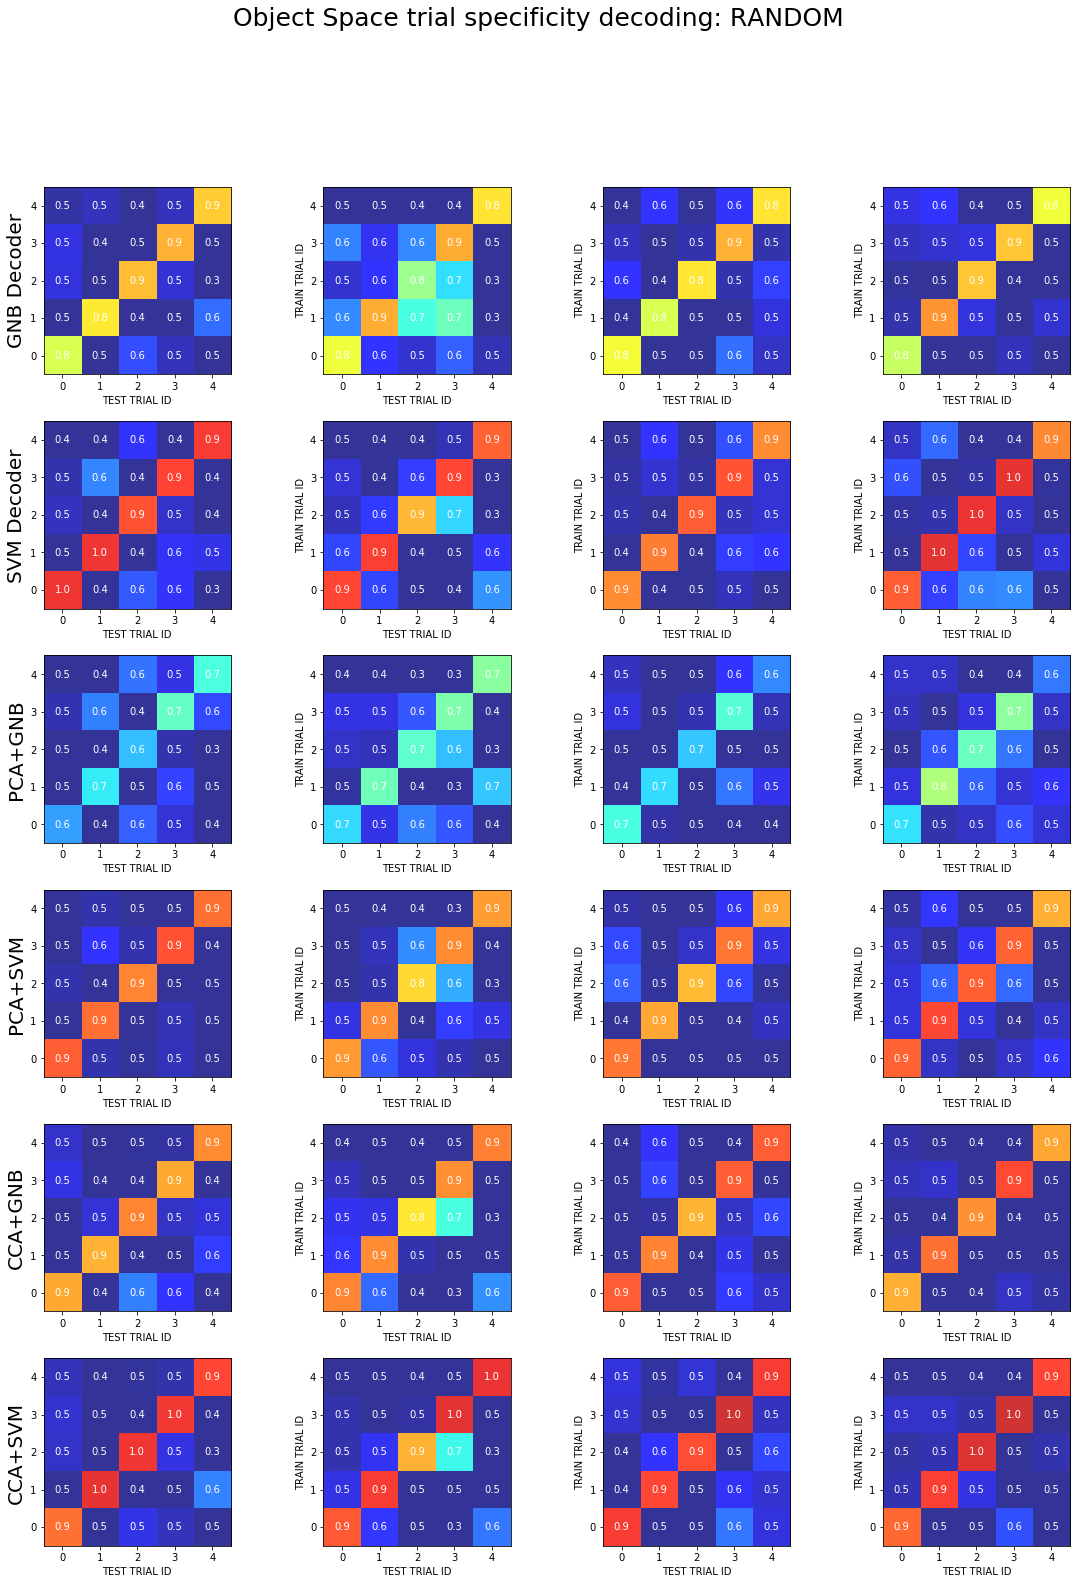

In [24]:
fig,ax = plt.subplots(6,4, figsize=(20,25))

conditions = labels[1:]

ploting_list = [score_matrix_gnb_list, score_matrix_svm_list, score_matrix_gnb_pca_list, score_matrix_svm_pca_list, score_matrix_gnb_cca_list, score_matrix_svm_cca_list  ]
labels = ['GNB Decoder','SVM Decoder','PCA+GNB','PCA+SVM','CCA+GNB','CCA+SVM']

for score in range(6):
    for day in [0,1,2,3]:
        plot_matrix = ploting_list[score][day]/counter
        #for i in range(5):
        #    plot_matrix[i,i]=0.5
        ax[score,day].imshow(plot_matrix, alpha = 0.8, origin = 'lower', cmap = 'jet', clim = [0.5,1])
        for i in range(5):
            for j in range(5):
                text = ax[score,day].text(j, i, round(plot_matrix[i,j],1),
                                         ha="center", va="center", color="w")          
        ax[score,0].set_ylabel(labels[score], fontsize = 20)

        ax[score,day].set_xlabel('TEST TRIAL ID')
        ax[score,day].set_ylabel('TRAIN TRIAL ID')

plt.subplots_adjust(wspace=0.01, hspace=0.25)
fig.suptitle('Object Space trial specificity decoding: ' + task , fontsize = 25)  

figure_name = figure_path +'decorder_trial_specificity_'+f'{mouse}'+'_session_'+f'{session}'+'.png'

fig.savefig(figure_name)